# Sections to run if cloned from repo
- Imports
- Handle Data
- Set Path Variables
- TF Model & Helper Functions
- Train CNN Model & Write Test Predictions

# Imports

In [1]:
import os
import math
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from skimage import io
from sklearn import metrics
from random import shuffle

c:\python38\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
c:\python38\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


# Handle Data

In [2]:
def read_audio(f_names: list, path: str):
    data   = [[]] * len(f_names)  # (data, samp_rate)
    srs     = [0] * len(f_names)
    labels = [0] * len(f_names)

    for i in range(len(f_names)):
        x, sr = librosa.load(path + f_names[i], sr=None, mono=True)
        data[i] = x
        srs[i] = sr

        if i % 100 == 0:
            print('i=', i, '\t num points:', x.shape, 'samp_rate:', sr)
    print("Finished reading", len(data), "audio files from", path,)
    return data, srs

def read_labels(f_names: list):
    labels = np.zeros(len(f_names))
    y_df = pd.read_csv('../res/train.csv', header=0, dtype={'new_id': str, 'genre': np.int16})
    y_df = y_df.set_index('new_id')
    for i in range(len(f_names)):
        labels[i] = y_df.loc[f_names[i][:-4]].genre
    print("Finished reading", len(labels), 'labels')
    return labels

def read_spectrogram(path: str, f_names: list):
    img_data = np.zeros(shape=(len(f_names), expected_spectro_shape[0], expected_spectro_shape[1]))
    for i in range(len(f_names)):
        spectro = io.imread(path + f_names[i][:-3] + 'png')

        if spectro.shape[1] > expected_spectro_shape[1]:
            spectro = spectro[:, :(expected_spectro_shape[1] - spectro.shape[1])]
        elif spectro.shape[1] < expected_spectro_shape[1]:
            padding_matrix_shape = (expected_spectro_shape[0], expected_spectro_shape[1] - spectro.shape[1])
            spectro = np.hstack((spectro, np.zeros(padding_matrix_shape)))

        img_data[i] = spectro
        if expected_spectro_shape != img_data[i].shape:
            print("index:", i, "has shape", img_data[i].shape)
    print("Spectrogram from", path, "read in! Shape is:", img_data.shape)
    return img_data

def save_audio_as_spectrogram(data: list, srs: list, f_names: list, path: str):
    def scale_minmax(x_audio, min=0.0, max=1.0):
        x_audio_std = (x_audio - x_audio.min()) / (x_audio.max() - x_audio.min())
        x_audio_scaled = x_audio_std * (max - min) + min
        return x_audio_scaled
    hop_length = 512  # samples per time sample
    time_steps= 2550  # width of data
    n_mels = 128  # height

    for i in range(len(f_names)):
        data[i] = data[i][:time_steps * hop_length]
        mels = librosa.feature.melspectrogram(y=data[i], sr=srs[i],
                                              n_mels=n_mels,
                                              n_fft=hop_length*2, hop_length=hop_length)
        mels = np.log(mels + 1e-9) # add small number to avoid log(0)

        # min-max scale to fit inside 8-bit range
        img = scale_minmax(mels, 0, 255).astype(np.uint8)
        img = np.flip(img, axis=0) # put low frequencies at the bottom in image
        img = 255 - img # invert. make black==more energy

        # save as PNG
        io.imsave(path + f_names[i][:-4] + '.png', img)

        if i % 100 == 0:
            print('i=', i, '\t img shape:', img.shape)
    print("Finished! Images saved to", path)

## Set Path Variables

In [3]:
train_wav_path = '../res/wav/train/'
test_wav_path = '../res/wav/test/'
train_spectro_path = '../res/spectrogram/train/'
test_spectro_path = '../res/spectrogram/test/'

train_wav_names = os.listdir(train_wav_path)
test_wav_names = os.listdir(test_wav_path)
train_spectro_names = os.listdir(train_spectro_path)
test_spectro_names = os.listdir(test_spectro_path)

expected_spectro_shape = (128, 2551)
num_classes = 6

img_rows = expected_spectro_shape[0]
img_cols = expected_spectro_shape[1]

print("num train wavs:", len(train_wav_names))
print("num test wavs:", len(test_wav_names))
print("num train spectros:", len(train_spectro_names))
print("num test spectros:", len(test_spectro_names))
print("expected_spectro_shape:", expected_spectro_shape)

num train wavs: 2400
num test wavs: 1200
num train spectros: 2400
num test spectros: 1200
expected_spectro_shape: (128, 2551)


## Read Training .wav Files and Save as Spectrograms
### ONLY RUN IS SPECTROGRAMS ARE NOT AVAILABLE (THEY'RE IN THE REPO UNDER res/spectrograms)

In [4]:
# DO NOT RUN IF SPECTROGRAMS ARE ALREADY IN res/spectrogram!!!!!!!!!!!!!!!!11
print("Number of train .wav files in audio folder:", len(train_wav_names))
training_wav, training_srs = read_audio(train_wav_names, train_wav_path)

save_audio_as_spectrogram(training_wav,
                          training_srs,
                          train_wav_names,
                          train_spectro_path)
# DO NOT RUN IF SPECTROGRAMS ARE ALREADY IN res/spectrogram!!!!!!!!!!!!!!!!11

Number of train .wav files in audio folder: 2400
i= 0 	 num points: (1321967,) samp_rate: 44100
i= 100 	 num points: (1321967,) samp_rate: 44100
i= 200 	 num points: (1321967,) samp_rate: 44100
i= 300 	 num points: (1323119,) samp_rate: 44100
i= 400 	 num points: (1321967,) samp_rate: 44100
i= 500 	 num points: (1321967,) samp_rate: 44100
i= 600 	 num points: (1323119,) samp_rate: 44100
i= 700 	 num points: (1321967,) samp_rate: 44100
i= 800 	 num points: (1321967,) samp_rate: 44100
i= 900 	 num points: (1323119,) samp_rate: 44100
i= 1000 	 num points: (1321967,) samp_rate: 44100
i= 1100 	 num points: (1321967,) samp_rate: 44100
i= 1200 	 num points: (1321967,) samp_rate: 44100
i= 1300 	 num points: (1323119,) samp_rate: 44100
i= 1400 	 num points: (1323119,) samp_rate: 44100
i= 1500 	 num points: (1439471,) samp_rate: 48000
i= 1600 	 num points: (1323119,) samp_rate: 44100
i= 1700 	 num points: (1321967,) samp_rate: 44100
i= 1800 	 num points: (1323119,) samp_rate: 44100
i= 1900 	 num

## Read Testing .wav Files and Save as Spectrograms
### ONLY RUN IS SPECTROGRAMS ARE NOT AVAILABLE (THEY'RE IN THE REPO UNDER res/spectrograms)

In [ ]:
# DO NOT RUN IF SPECTROGRAMS ARE ALREADY IN res/spectrogram!!!!!!!!!!!!!!!!11
print("Number of train .wav files in audio folder:", len(test_wav_names))
testing_wav, testing_srs = read_audio(test_wav_names, test_wav_path)

save_audio_as_spectrogram(testing_wav,
                          testing_srs,
                          test_wav_names,
                          test_spectro_path)
# DO NOT RUN IF SPECTROGRAMS ARE ALREADY IN res/spectrogram!!!!!!!!!!!!!!!!11


# TF Model & Helper Functions

In [4]:
def calc_CI(score, sample_size):
    print('CI = %.2f' % (math.sqrt(score * (1 - score) / sample_size) * 100))

def format_data(data):
    img_rows = expected_spectro_shape[0]
    img_cols = expected_spectro_shape[1]
    if K.image_data_format() == 'channels_first':
        data_x = data.reshape(data.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        data_x = data.reshape(data.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
    return data_x, input_shape

def plot_conf_matrix(acc, conf_array):
    fig, ax = plt.subplots()
    ax.imshow(conf_array)
    labels = "Rock,Pop,Folk,Instr,Elec,HH".split(',')
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, "%.2f" % conf_array[i, j], ha="center", va="center", color="w")

    ax.set_title("The Confusion Matrix")
    fig.tight_layout()
    plt.savefig("../res/confMat/confMat_cnn_acc" + str(acc) + ".png", bbox_inches='tight', pad_inches=0.3)
    plt.show()

def create_1D_CNN(input_shape):
    model = keras.models.Sequential()
    # model.add(layers.Conv1D(filters=4, kernel_size=8, activation='relu', input_shape=input_shape))
    model.add(layers.Conv1D(filters=8, kernel_size=16, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool1D(2))

    model.add(layers.Conv1D(filters=8, kernel_size=16, activation='relu'))
    # model.add(layers.Conv1D(filters=8, kernel_size=32, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool1D(2))
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.sparse_categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=.09),
                  metrics=['accuracy'])

    return model

# Train CNN Model & Write Test Predictions

Spectrogram from ../res/spectrogram/train/ read in! Shape is: (2400, 128, 2551)
Finished reading 2400 labels



(2400, 128, 2551)
(2040,)
(360,)



Epoch 1/2
64/64 [==============================] - 41s 642ms/step - loss: 1.8154 - accuracy: 0.2431 - val_loss: 1.8309 - val_accuracy: 0.1556

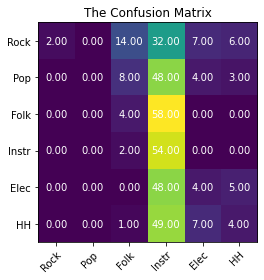

In [5]:
def train_and_write_file():
    training_x = read_spectrogram(train_spectro_path, train_spectro_names)
    training_labels = read_labels(train_spectro_names)

    shuffle_training_x_labs = list(zip(training_x, training_labels))
    shuffle(shuffle_training_x_labs)

    training_x = np.array([x for x, _ in shuffle_training_x_labs])
    training_labels = np.array([l for _, l in shuffle_training_x_labs])

    train_size = int(len(training_x) * .85)

    train_set_x = training_x[:train_size]
    train_set_y = training_labels[:train_size]
    eval_set_x = training_x[train_size:]
    eval_set_y = training_labels[train_size:]
    print()
    print(training_x.shape)
    print(train_set_y.shape)
    print(eval_set_y.shape)
    print()

    # model = create_CNN_1d(input_shape=(img_rows, img_cols)) # Sahba's
    model = create_1D_CNN(input_shape=(img_rows, img_cols))  # Mauricio's
    model.fit(train_set_x, train_set_y,
              epochs=50,
              # batch_size=20,  # @TODO if computer isn't powerful enough, lower int
              verbose=1,
              validation_data=(eval_set_x, eval_set_y),
              use_multiprocessing=True)

    model.summary()
    score = model.evaluate(training_x[train_size:], eval_set_y, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    predictions = model.predict(eval_set_x)
    matrix = metrics.confusion_matrix(eval_set_y, predictions.argmax(axis=1))
    print(matrix)
    plot_conf_matrix(score[1], matrix)
    calc_CI(score=score[1], sample_size=len(eval_set_y))

    if score[1] > .55:
        testing_x = read_spectrogram(test_spectro_path, test_spectro_names)
        predictions = model.predict(testing_x)
        with open('../results/CNN_' + str(score[1]) + '.csv', 'w') as csv_stream:
            csv_stream.write('id,genre\n')
            for r in range(predictions.shape[0]):
                predicted_genre = np.argmax(predictions[r, :])
                file_label = test_spectro_names[r][:-4]
                csv_stream.write(f"{file_label},{predicted_genre}\n")
        print('File written to:', '../results/CNN_' + str(score[1]) + '.csv')

train_and_write_file()